In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_train_DF_{}.pkl".format(SIZE_X))
val_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/val_DF_{}.pkl".format(SIZE_X))
test_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/test_DF_{}.pkl".format(SIZE_X))

In [5]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

In [6]:
aug_train_DF["Images"] = aug_train_DF["Images"].apply(normalize)
val_DF["Images"] = val_DF["Images"].apply(normalize)
test_DF["Images"] = test_DF["Images"].apply(normalize)

In [7]:
classes_dict = {"Not Tumor": 0, "Meningioma": 1, "Glioma": 2, "Pituitary": 3}
for index, row in aug_train_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
for index, row in val_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
for index, row in test_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]

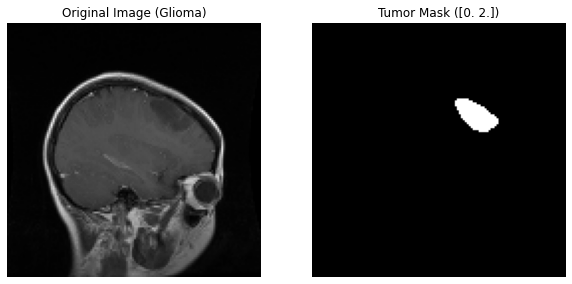

In [8]:
randInt = np.random.randint(0,len(aug_train_DF))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

img  = aug_train_DF.Images[randInt]
mask = aug_train_DF["Tumor Mask"][randInt]


# Display Original Image
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image ({})'.format(aug_train_DF.Labels[randInt]))
plt.axis('off')
  
# Display Tumor Mask
fig.add_subplot(rows, columns, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask ({})'.format(np.unique(mask)))
plt.axis('off')
plt.show()

In [9]:
aug_train_DF.head()

,PID,Images,Tumor Mask,Labels
0,99288,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1,112002,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
2,103046,"[[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Pituitary
3,103925,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 5, 4,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
4,MR052585B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma


In [10]:
test_DF.head()

,PID,Images,Tumor Mask,Labels
1696,MR017260F,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
2653,113435,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1408,MR049358,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
2300,106720,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1348,MR040240B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma


In [11]:
y_train = aug_train_DF["Tumor Mask"].tolist()
X_train = aug_train_DF['Images'].tolist()
y_train = np.array(y_train).reshape(-1, SIZE_X, SIZE_Y)
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y)


y_val = val_DF["Tumor Mask"].tolist()
X_val = val_DF['Images'].tolist()
y_val = np.array(y_val).reshape(-1, SIZE_X, SIZE_Y)
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y)

y_test = test_DF["Tumor Mask"].tolist()
X_test = test_DF['Images'].tolist()
y_test = np.array(y_test).reshape(-1, SIZE_X, SIZE_Y)
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y)


print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128) | y_train shape: (9192, 128, 128)
X_val shape  : (306, 128, 128)  | y_test shape :  (306, 128, 128)
X_test shape : (460, 128, 128)  | y_test shape :  (460, 128, 128)


In [12]:
y_train = np.expand_dims(y_train, axis=3)
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train/255

y_val = np.expand_dims(y_val, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_val = X_val/255

y_test = np.expand_dims(y_test, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_test = X_test/255

print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128, 1) | y_train shape: (9192, 128, 128, 1)
X_val shape  : (306, 128, 128, 1)  | y_test shape :  (306, 128, 128, 1)
X_test shape : (460, 128, 128, 1)  | y_test shape :  (460, 128, 128, 1)


In [13]:
n_classes = len(np.unique(y_train))
n_classes

4

In [14]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [15]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train_cat.shape)
print("X_val shape:  ", X_val.shape,"| y_train shape: ", y_val_cat.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test_cat.shape)

X_train shape: (9192, 128, 128, 1) | y_train shape: (9192, 128, 128, 4)
X_val shape:   (306, 128, 128, 1) | y_train shape:  (306, 128, 128, 4)
X_test shape : (460, 128, 128, 1) | y_test shape :  (460, 128, 128, 4)


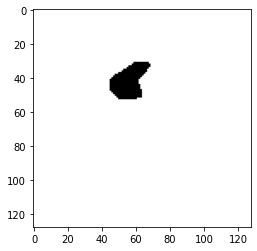

In [16]:
plt.imshow(y_test_cat[0, :, :, 0], 'gray')

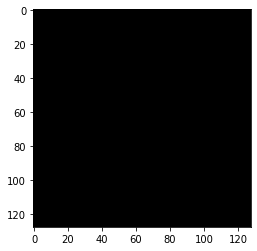

In [17]:
plt.imshow(y_test_cat[0, :, :, 1], 'gray')

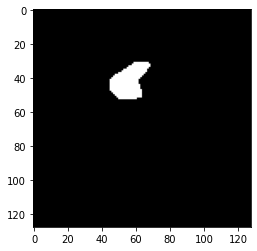

In [18]:
plt.imshow(y_test_cat[0, :, :, 2], 'gray')

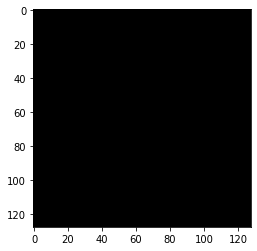

In [19]:
plt.imshow(y_test_cat[0, :, :, 3], 'gray')

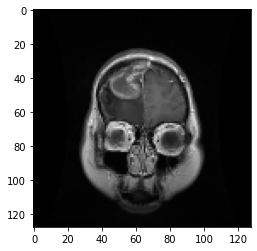

In [20]:
plt.imshow(X_test[0, :, :, :], 'gray')

In [21]:
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = labelencoder.fit_transform(y_train.reshape(-1,1).ravel()))
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

Class weights are...: [ 0.25428871 60.20591626 24.58038019 98.33275527]


In [22]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(n_classes, input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [23]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [24]:
import segmentation_models as sm

activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [25]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(n_classes, input_shape)
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint



model_checkpoint_callback = ModelCheckpoint(
    filepath= os.path.join(weights, "best.h5"),
    verbose=100, 
    save_best_only=False, 
    mode='max')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss val_accuracy', patience = 10)
    
history = model.fit(X_train, 
        y_train_cat, 
        batch_size = 32, 
        verbose=1, 
        epochs=120, 
        validation_data=(X_val, y_val_cat), 
        callbacks=[model_checkpoint_callback],
        shuffle=False)



Epoch 1/120
288/288 [==============================] - 73s 225ms/step - loss: 0.9204 - iou_score: 0.2367 - f1-score: 0.2397 - val_loss: -13.1848 - val_iou_score: 0.4207 - val_f1-score: 0.4228

Epoch 00001: saving model to ./experiments/exp#13\weights\best.h5
Epoch 2/120
288/288 [==============================] - 61s 212ms/step - loss: 0.9540 - iou_score: 0.2458 - f1-score: 0.2479 - val_loss: -13.1848 - val_iou_score: 0.4207 - val_f1-score: 0.4228

Epoch 00002: saving model to ./experiments/exp#13\weights\best.h5
Epoch 3/120
288/288 [==============================] - 61s 212ms/step - loss: 0.9540 - iou_score: 0.2458 - f1-score: 0.2479 - val_loss: -13.1848 - val_iou_score: 0.4207 - val_f1-score: 0.4228

Epoch 00003: saving model to ./experiments/exp#13\weights\best.h5
Epoch 4/120
288/288 [==============================] - 61s 213ms/step - loss: 0.9540 - iou_score: 0.2458 - f1-score: 0.2479 - val_loss: -13.1848 - val_iou_score: 0.4207 - val_f1-score: 0.4228

Epoch 00004: saving model to .

In [ ]:
# acc = model.evaluate(X_test, y_test_cat)
# name = str(round(acc, 4))

In [ ]:
# Save The Trained model along with it training history   
metrics = pd.DataFrame(history.history)
metrics.to_pickle(os.path.join(results, "metrics"+'.pkl'))
model.save(os.path.join(weights, "First_Mulit_UNet" + '.h5'))

In [ ]:
pd.DataFrame(history.history)

In [ ]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.legend()

plt.show()

acc = metrics['iou_score']
val_acc = metrics['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(os.path.join(results, 'IoU.png'))
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

In [ ]:
def prob_class(predicted_img, class_dic):
    rev_classes_dict = dict([(value, key) for key, value in class_dic.items()])
    result = ""
    if len(np.unique(predicted_img)) == 1:
        result = "(No Tumor)"
    else:
        for cls in np.unique(predicted_img):
            if cls != 0:
                prob = (predicted_img == cls).sum() / (0 != predicted_img).sum() 
                result += "({} {}%) ".format(rev_classes_dict[cls], str( round(prob*100, 2) ))

    return result

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]



intersection = np.logical_and(ground_truth[:,:,0], predicted_img)
union = np.logical_or(ground_truth[:,:,0], predicted_img)
iou_score = np.sum(intersection) / np.sum(union)

accuracy = str(round(iou_score * 100, 1))



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label\nClasses: ({})'.format(rev_classes_dict[np.unique(ground_truth)[1]]))
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image\nClasses: {}\nIoU: {}%'.format(prob_class(predicted_img, classes_dict), accuracy))
plt.imshow(predicted_img, cmap='jet')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

In [ ]:
import os. path.
​
save_path = 'C:/example/'
​
name_of_file = raw_input("What is the name of the file: ")
​
completeName = os. path. join(save_path, name_of_file+".txt")